<a href="https://colab.research.google.com/github/Hrenani/Language_modeling/blob/main/language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#language modeling

In [1]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 41.1 MB/s eta 0:00:00


In [2]:
# Install PyTorch 2.0.1+cu118
!pip install torch==2.0.1+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install torchtext 0.15.2+cpu
!pip install torchtext==0.15.2+cpu --index-url https://download.pytorch.org/whl/cpu

# Install tqdm
!pip install tqdm==4.66.1

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 514.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

## Import the required libraries and frameworks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader,IterableDataset, random_split

import torch.optim as optim
import torchmetrics as tm

import tqdm

from collections import Counter

In [2]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.0.1+cu118
torchtext --> 0.15.2+cpu
tqdm --> 4.66.1


### These two functions to average the values ​​simplify our work in model training.

In [3]:
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n =1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [4]:
def num_trainable_params(model):
  nums =  sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [5]:
!pip install portalocker>=2.0.0

In [10]:
from google.colab import files
uploaded = files.upload()

Saving wikitext-2-v1.zip to wikitext-2-v1.zip


In [11]:
!unzip /content/wikitext-2-v1.zip

Archive:  /content/wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


##Call data

In [26]:
train_path = '/content/wikitext-2/wiki.train.tokens'
valid_path = '/content/wikitext-2/wiki.valid.tokens'
test_path = '/content/wikitext-2/wiki.test.tokens'

def read_data_generator(file_path):
    with open(file_path, 'r') as f:
        for line in f:
            yield line

train_iter = read_data_generator(train_path)
valid_iter = read_data_generator(valid_path)
test_iter = read_data_generator(test_path)


In [ ]:
train_iter_ = iter(train_iter)
train_iter_

<generator object read_data_generator at 0x7d9021c47990>

In [ ]:
next(train_iter_)

' \n'

In [ ]:
total_sentence_count = 0
total_sentence_length = 0

for line in train_iter:
    sentences = line.split('.')

    for sentence in sentences:
        tokens = sentence.strip().split()
        sentence_length = len(tokens)

        if sentence_length > 0:
            total_sentence_count += 1
            total_sentence_length += sentence_length

mean_sentence_length = total_sentence_length / (total_sentence_count)

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


In [7]:
txt = ["Hi Hosein I am kooon :) nad yuo44 @tke ", "you are yoiu!",":"]
tokenizer = get_tokenizer('basic_english')
list(map(tokenizer,txt))

[['hi', 'hosein', 'i', 'am', 'kooon', ')', 'nad', 'yuo44', '@tke'],
 ['you', 'are', 'yoiu', '!'],
 []]

##Preparing to tokenize the model

In [8]:
vocab = build_vocab_from_iterator(map(tokenizer, txt), specials=['<ukn>'], min_freq=2)
vocab.set_default_index(vocab['<ukn>'])
vocab.get_stoi()

{'<ukn>': 0}

In [13]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [14]:
len(vocab)

28782

In [15]:
vocab.get_stoi()

{'攻殻機動隊': 28781,
 '戦場のヴァルキュリア3': 28780,
 'წ': 28776,
 'ც': 28774,
 'ზ': 28770,
 'გ': 28768,
 '์': 28767,
 'ง': 28765,
 'กัลยาณมิตร': 28764,
 'γ': 28761,
 'łaszcz': 28759,
 'ürümqi': 28757,
 'último': 28756,
 'ø': 28754,
 'ösel': 28753,
 'être': 28752,
 'élodie': 28749,
 'álvaro': 28748,
 '§': 28747,
 'zuzanna': 28745,
 'zuniga': 28744,
 'zoromski': 28742,
 'zongwang': 28741,
 'zhu': 28737,
 'zhishen': 28736,
 'zhejiang': 28735,
 'zhao': 28734,
 'zatanna': 28728,
 'yvonne': 28720,
 'yurikago': 28719,
 'yukizuki': 28717,
 'ysabel': 28713,
 'youngsters': 28711,
 'yorkers': 28710,
 'yiddish': 28705,
 'yesterday': 28704,
 'yeoh': 28703,
 'yen': 28702,
 'yellowwoods': 28701,
 'yarder': 28698,
 'yammer': 28696,
 'yamamoto': 28695,
 'xlvii': 28694,
 'xfx': 28692,
 'xamar': 28691,
 'wumpa': 28686,
 'wsmv': 28685,
 'wrists': 28684,
 'wrapping': 28683,
 'worshippers': 28681,
 'worshiping': 28680,
 'worrisome': 28679,
 'workload': 28678,
 'workhouse': 28677,
 'worf': 28676,
 'woodcut': 28673,
 'wo

In [19]:
freqs = Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [20]:
freqs.most_common()[-6000:]

[('refreshing', 4),
 ('aback', 4),
 ('uproar', 4),
 ('novi', 4),
 ('mshd', 4),
 ('881', 4),
 ('ibrahima', 4),
 ('1726', 4),
 ('mandé', 4),
 ('yalunka', 4),
 ('bundu', 4),
 ('almami', 4),
 ('donnel', 4),
 ('cctv', 4),
 ('fiancée', 4),
 ('fibres', 4),
 ('calmly', 4),
 ('gaviria', 4),
 ('andes', 4),
 ('stylized', 4),
 ('40th', 4),
 ('zurich', 4),
 ('rafa', 4),
 ('jonas', 4),
 ('mcenroe', 4),
 ('tiebreaker', 4),
 ('borg', 4),
 ('racquets', 4),
 ('battled', 4),
 ('tiebreak', 4),
 ('surpass', 4),
 ('prolonging', 4),
 ('baseline', 4),
 ('forehand', 4),
 ('dogfights', 4),
 ('simulators', 4),
 ('graphical', 4),
 ('hantzopoulos', 4),
 ('gauges', 4),
 ('itcz', 4),
 ('accelerating', 4),
 ('mudskippers', 4),
 ('tasting', 4),
 ('bbdo', 4),
 ('squirrels', 4),
 ('mustang', 4),
 ('overlapped', 4),
 ('stella', 4),
 ('mulhall', 4),
 ('windass', 4),
 ('oblivion', 4),
 ('californicus', 4),
 ('diets', 4),
 ('rabbits', 4),
 ('mites', 4),
 ('hares', 4),
 ('sonora', 4),
 ('wheatgrass', 4),
 ('coyote', 4),
 ('l

##Data preprocessing and preparation process

In [21]:
def data_process(text_iter,seq_len):
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in text_iter])

  M = len(data) // seq_len
  r = len(data) % seq_len
  data = torch.cat((data,torch.LongTensor([0]))) if r == 0 else data

  inputs = data[: M*seq_len]
  inputs = inputs.reshape(-1,seq_len)

  targets = data[1: M*seq_len+1]
  targets = targets.reshape(-1,seq_len)

  return inputs,targets

In [23]:
inputs, targets = data_process(text_iter=train_iter,seq_len=120)
inputs.shape,targets.shape

(torch.Size([17083, 120]), torch.Size([17083, 120]))

In [24]:
del  inputs, targets

In [27]:
seq_len = 35

x_train,y_train = data_process(text_iter=train_iter ,seq_len=seq_len)
x_valid, y_valid = data_process(text_iter=valid_iter,seq_len=seq_len)
x_test, y_test = data_process(text_iter=test_iter,seq_len=seq_len)

x_train.shape,y_train.shape,x_valid.shape,y_valid.shape,x_test.shape,y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

##custom dataset

In [28]:
class LanguageModelDataset(Dataset):
  def __init__(self,inputs,targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self,idx):
    return self.inputs[idx],self.targets[idx]

In [29]:
train_set = LanguageModelDataset(x_train,y_train)
valid_set = LanguageModelDataset(x_valid,y_valid)
test_set = LanguageModelDataset(x_test,y_test)

In [30]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

In [31]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle= True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle= False)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle= False)

In [32]:
x_iter, y_iter = next(iter(train_loader))
x_iter.shape,y_iter.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

## language Model class

In [33]:
class LanguageModel(nn.Module):
  def __init__(self,vocab_size, embedding_dim, hidden_dim,num_layers, dropout_embd= 0.5, dropout_rnn= 0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1,0.1)
    self.dropout = nn.Dropout(p = dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, dropout= dropout_rnn, batch_first = True)
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction

In [34]:
model = LanguageModel(vocab_size= len(vocab),
                      embedding_dim= 300,
                      hidden_dim = 512,
                      num_layers= 2,
                      dropout_embd= 0.65,
                      dropout_rnn= 0.5)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [35]:
x_batch, y_batch = next(iter(train_loader))

model(x_batch).shape

torch.Size([20, 35, 28782])

In [36]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(8.6346, 3.76832, 14.765166)

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [40]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim, hidden_dim,
                      num_layers, dropout_embd, dropout_rnn).to(device)

In [41]:
optimizser = optim.SGD(model.parameters(), lr = 0.5, weight_decay=0, momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

In [42]:
class Perplexity(tm.Metric):
    def __init__(self):
        super(Perplexity, self).__init__()
        self.add_state("total_loss", default=torch.tensor(0.0).to(device), dist_reduce_fx="sum")  # Ensure on device
        self.add_state("num_samples", default=torch.tensor(0).to(device), dist_reduce_fx="sum")  # Ensure on device
        self.criterion = nn.CrossEntropyLoss(reduction='sum')  # Summing losses

    def update(self, logits, labels):
        # Ensure logits and labels are on the same device as the metric
        logits = logits.to(device)
        labels = labels.to(device)

        # Calculate the loss
        loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        self.total_loss += loss
        self.num_samples += labels.numel()  # Count total number of labels

    def compute(self):
        # Calculate perplexity
        return torch.exp(self.total_loss / self.num_samples)

    def reset(self):
        # Reset states for next evaluation
        self.total_loss = torch.tensor(0.0).to(device)
        self.num_samples = torch.tensor(0).to(device)

In [43]:
metric = Perplexity().to(device)
clip = 0.25

## train function and avaluate function

In [44]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch= None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit= "epoch") as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f"Epoch {epoch}")

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm= clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n= len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss= loss_train.avg, metric = metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [45]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

In [46]:
model = LanguageModel(len(vocab), embedding_dim= 300, hidden_dim= 512, num_layers= 2,
                      dropout_embd= 0.5, dropout_rnn= 0.2,).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(10.2692, device='cuda:0')


In [47]:
outputs.reshape(-1, outputs.shape[-1]).shape, targets.flatten().shape

(torch.Size([700, 28782]), torch.Size([700]))

In [48]:
torch.cuda.empty_cache()

In [49]:
model = LanguageModel(len(vocab), embedding_dim= 300, hidden_dim=512,
                      num_layers= 2, dropout_embd= 0.5, dropout_rnn= 0.2).to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.9, momentum= 0.9)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set) - mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:01<00:00, 25.64epoch/s, loss=0.271, metric=1.31]


## To initialize hyper parameters

In [ ]:
num_epoch = 1
for lr in [2, 0.9, 0.5, 0.3, 0.09, 0.05]:
  print(f"LR = {lr}")

  model = LanguageModel(len(vocab), embedding_dim=300,
                        hidden_dim= 512, num_layers= 2,
                        dropout_embd = 0.5, dropout_rnn = 0.2).to(device)

  optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epoch):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR = 2


100%|██████████| 2929/2929 [01:51<00:00, 26.23epoch/s, loss=5.97, metric=390]



LR = 0.9


100%|██████████| 2929/2929 [01:51<00:00, 26.30epoch/s, loss=6.18, metric=484]



LR = 0.5


100%|██████████| 2929/2929 [01:51<00:00, 26.22epoch/s, loss=6.43, metric=622]



LR = 0.3


  3%|▎         | 86/2929 [00:03<01:50, 25.77epoch/s, loss=8.3, metric=4.02e+3]


KeyboardInterrupt: 

In [ ]:
num_epoch = 1
for lr in [5,3,1]:
  print(f"LR = {lr}")

  model = LanguageModel(len(vocab), embedding_dim=300,
                        hidden_dim= 512, num_layers= 2,
                        dropout_embd = 0.5, dropout_rnn = 0.2).to(device)

  optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epoch):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR = 5


100%|██████████| 2929/2929 [01:51<00:00, 26.16epoch/s, loss=5.83, metric=339]



LR = 3


100%|██████████| 2929/2929 [01:51<00:00, 26.19epoch/s, loss=5.89, metric=363]



LR = 1


  3%|▎         | 97/2929 [00:03<01:49, 25.95epoch/s, loss=7.85, metric=2.56e+3]


KeyboardInterrupt: 

In [ ]:
num_epoch = 1
for lr in [7,6]:
  print(f"LR = {lr}")

  model = LanguageModel(len(vocab), embedding_dim=300,
                        hidden_dim= 512, num_layers= 2,
                        dropout_embd = 0.5, dropout_rnn = 0.2).to(device)

  optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epoch):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR = 7


100%|██████████| 2929/2929 [01:53<00:00, 25.86epoch/s, loss=5.87, metric=355]



LR = 6


100%|██████████| 2929/2929 [01:52<00:00, 26.13epoch/s, loss=5.85, metric=348]

In [ ]:
num_epochs = 1
lr = 5
for wd in [1e-4,1e-5, 1e-8, 0]:
  print(f"LR={lr}, Wd= {wd}")

  model = LanguageModel(len(vocab), embedding_dim=300,
                        hidden_dim= 512, num_layers= 2,
                        dropout_embd = 0.5, dropout_rnn = 0.2).to(device)
  optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=5, Wd= 0.0001


100%|██████████| 2929/2929 [01:52<00:00, 26.09epoch/s, loss=6.33, metric=562]



LR=5, Wd= 1e-05


100%|██████████| 2929/2929 [01:53<00:00, 25.86epoch/s, loss=5.9, metric=365]



LR=5, Wd= 1e-08


100%|██████████| 2929/2929 [01:51<00:00, 26.25epoch/s, loss=5.83, metric=339]



LR=5, Wd= 0


100%|██████████| 2929/2929 [01:47<00:00, 27.16epoch/s, loss=5.82, metric=338]

# Training

In [ ]:
lr = 5
wd = 1e-8
optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  #train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  #validation
  loss_valid, metric_valid = evaluate(model,
                                             valid_loader,
                                             loss_fn,
                                             metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f"model.pt")
    best_loss_valid = loss_valid
    print("Model Saved")

    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:56<00:00, 25.09epoch/s, loss=5.26, metric=193]


Model Saved
Valid: Loss = 5.142, Metric = 171.0



Epoch 2: 100%|██████████| 2929/2929 [01:56<00:00, 25.20epoch/s, loss=5.06, metric=158]


Model Saved
Valid: Loss = 5.088, Metric = 162.1



Epoch 3: 100%|██████████| 2929/2929 [01:56<00:00, 25.18epoch/s, loss=4.92, metric=137]


Model Saved
Valid: Loss = 5.088, Metric = 162.0



Epoch 4: 100%|██████████| 2929/2929 [01:56<00:00, 25.19epoch/s, loss=4.81, metric=123]


Epoch 5: 100%|██████████| 2929/2929 [01:56<00:00, 25.20epoch/s, loss=4.72, metric=112]


Model Saved
Valid: Loss = 5.071, Metric = 159.3



Epoch 6: 100%|██████████| 2929/2929 [01:56<00:00, 25.21epoch/s, loss=4.65, metric=104]


Epoch 7: 100%|██████████| 2929/2929 [01:56<00:00, 25.20epoch/s, loss=4.58, metric=97.7]


Epoch 8: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=4.53, metric=92.3]


Epoch 9: 100%|██████████| 2929/2929 [01:56<00:00, 25.14epoch/s, loss=4.47, metric=87.5]


Epoch 10: 100%|██████████| 2929/2929 [01:56<00:00, 25.20epoch/s, loss=4.42, metric=83.5]


Epoch 11: 100%|██████████| 2929/2929 [01:55<00:00, 25.28epoch/s, loss=4.38, metric=80]


Epoch 12: 100%|██████████| 2929/2929 [01:56<00:00, 25.23epoch/s, loss=4.34, metric=77]


Epoch 13: 100%|██████████| 2929/2929 [01:55<00:00, 25.25epoch/s, loss=4.31, metric=74.4]


Epoch 14: 100%|██████████| 2929/2929 [01:55<00:00, 25.28epoch/s, loss=4.28, metric=72]


Epoch 15: 100%|██████████| 2929/2929 [01:57<00:00, 24.88epoch/s, loss=4.25, metric=69.8]


Epoch 16: 100%|██████████| 2929/2929 [01:56<00:00, 25.16epoch/s, loss=4.22, metric=68]


Epoch 17: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=4.19, metric=66.2]


Epoch 18: 100%|██████████| 2929/2929 [01:56<00:00, 25.25epoch/s, loss=4.17, metric=64.7]


Epoch 19: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=4.15, metric=63.4]


Epoch 20: 100%|██████████| 2929/2929 [01:56<00:00, 25.24epoch/s, loss=4.13, metric=62]


Epoch 21: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=4.11, metric=60.8]


Epoch 22: 100%|██████████| 2929/2929 [01:56<00:00, 25.21epoch/s, loss=4.09, metric=59.8]


Epoch 23: 100%|██████████| 2929/2929 [01:56<00:00, 25.22epoch/s, loss=4.07, metric=58.6]


Epoch 24: 100%|██████████| 2929/2929 [01:56<00:00, 25.22epoch/s, loss=4.05, metric=57.6]


Epoch 25: 100%|██████████| 2929/2929 [01:56<00:00, 25.23epoch/s, loss=4.04, metric=56.8]


Epoch 26: 100%|██████████| 2929/2929 [01:56<00:00, 25.23epoch/s, loss=4.02, metric=55.9]


Epoch 27: 100%|██████████| 2929/2929 [01:58<00:00, 24.69epoch/s, loss=4.01, metric=55.2]


Epoch 28: 100%|██████████| 2929/2929 [01:56<00:00, 25.14epoch/s, loss=4, metric=54.5]


Epoch 29: 100%|██████████| 2929/2929 [01:56<00:00, 25.17epoch/s, loss=3.99, metric=53.9]


Epoch 30: 100%|██████████| 2929/2929 [01:56<00:00, 25.15epoch/s, loss=3.98, metric=53.4]


# learning curve

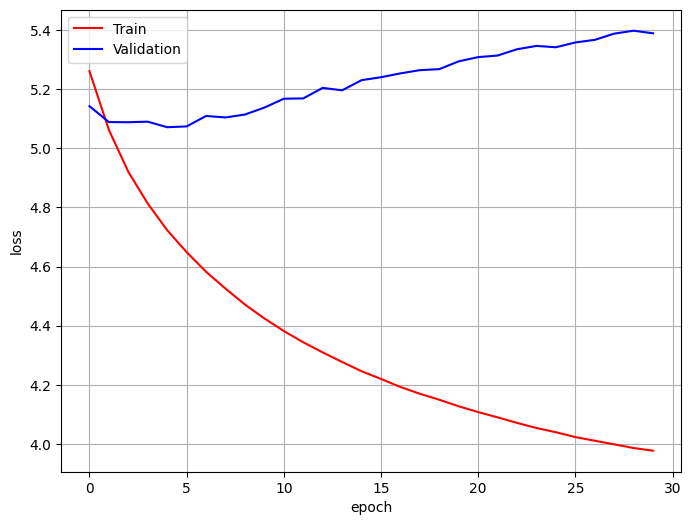

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = "Train")
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = "Validation")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid(True)
plt.legend()

In [ ]:
lr = 0.9
wd = 1e-8
optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  #train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  #validation
  loss_valid, metric_valid = evaluate(model,
                                             valid_loader,
                                             loss_fn,
                                             metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f"model_2.pt")
    best_loss_valid = loss_valid
    print("Model Saved")

    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:56<00:00, 25.13epoch/s, loss=3.74, metric=42.1]


Model Saved
Valid: Loss = 5.336, Metric = 207.7



Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=3.71, metric=40.8]


Model Saved
Valid: Loss = 5.336, Metric = 207.6



Epoch 3: 100%|██████████| 2929/2929 [01:55<00:00, 25.25epoch/s, loss=3.68, metric=39.8]


Epoch 4: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=3.67, metric=39.1]


Epoch 5: 100%|██████████| 2929/2929 [01:56<00:00, 25.25epoch/s, loss=3.65, metric=38.4]


Epoch 6: 100%|██████████| 2929/2929 [01:55<00:00, 25.28epoch/s, loss=3.63, metric=37.9]


Epoch 7:   4%|▍         | 111/2929 [00:04<01:52, 25.08epoch/s, loss=3.58, metric=35.9]


KeyboardInterrupt: 

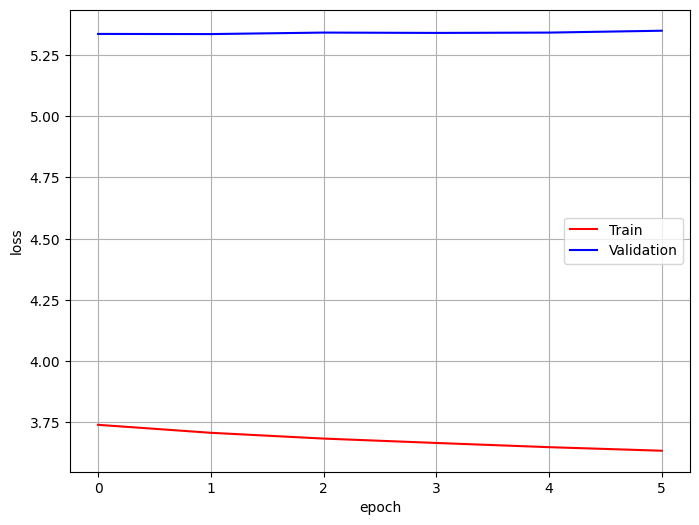

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = "Train")
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = "Validation")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid(True)
plt.legend()

In [ ]:
lr = 2.0
wd = 1e-8
optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  #train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  #validation
  loss_valid, metric_valid = evaluate(model,
                                             valid_loader,
                                             loss_fn,
                                             metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f"model_2.pt")
    best_loss_valid = loss_valid
    print("Model Saved")

    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:57<00:00, 24.91epoch/s, loss=3.69, metric=39.9]


Model Saved
Valid: Loss = 5.361, Metric = 212.9



Epoch 2: 100%|██████████| 2929/2929 [01:56<00:00, 25.20epoch/s, loss=3.68, metric=39.5]


Epoch 3: 100%|██████████| 2929/2929 [01:56<00:00, 25.23epoch/s, loss=3.66, metric=38.9]


Epoch 4: 100%|██████████| 2929/2929 [01:55<00:00, 25.26epoch/s, loss=3.64, metric=38.2]


Epoch 5: 100%|██████████| 2929/2929 [01:55<00:00, 25.27epoch/s, loss=3.63, metric=37.8]


Epoch 6:  47%|████▋     | 1379/2929 [00:54<01:01, 25.32epoch/s, loss=3.58, metric=36]


KeyboardInterrupt: 

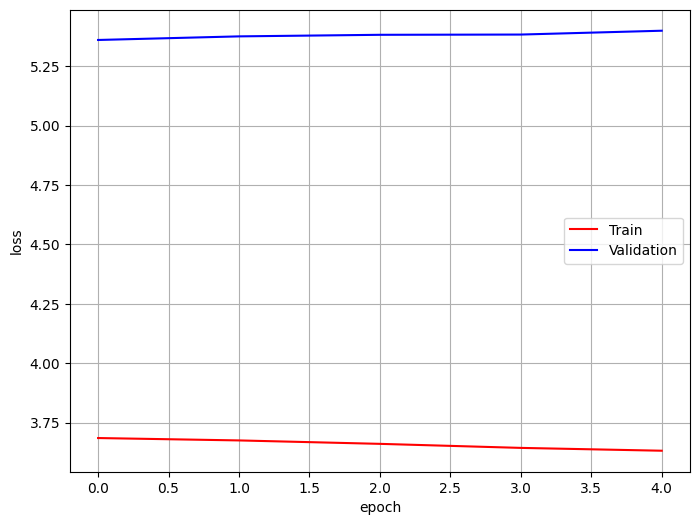

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = "Train")
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = "Validation")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid(True)
plt.legend()

In [ ]:
lr = 3.0
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  #train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  #validation
  loss_valid, metric_valid = evaluate(model,
                                             valid_loader,
                                             loss_fn,
                                             metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f"model_3.pt")
    best_loss_valid = loss_valid
    print("Model Saved")

    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:56<00:00, 25.04epoch/s, loss=3.75, metric=42.6]


Model Saved
Valid: Loss = 5.252, Metric = 190.9



Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.28epoch/s, loss=3.78, metric=43.9]


Model Saved
Valid: Loss = 5.219, Metric = 184.8



Epoch 3: 100%|██████████| 2929/2929 [01:56<00:00, 25.24epoch/s, loss=3.81, metric=45.2]


Model Saved
Valid: Loss = 5.206, Metric = 182.4



Epoch 4: 100%|██████████| 2929/2929 [01:56<00:00, 25.24epoch/s, loss=3.83, metric=46.3]


Model Saved
Valid: Loss = 5.188, Metric = 179.2



Epoch 5: 100%|██████████| 2929/2929 [01:56<00:00, 25.20epoch/s, loss=3.85, metric=47.1]


Model Saved
Valid: Loss = 5.174, Metric = 176.6



Epoch 6: 100%|██████████| 2929/2929 [01:56<00:00, 25.22epoch/s, loss=3.87, metric=47.9]


Model Saved
Valid: Loss = 5.162, Metric = 174.6



Epoch 7: 100%|██████████| 2929/2929 [01:56<00:00, 25.17epoch/s, loss=3.88, metric=48.3]


Model Saved
Valid: Loss = 5.157, Metric = 173.6



Epoch 8: 100%|██████████| 2929/2929 [01:56<00:00, 25.18epoch/s, loss=3.88, metric=48.6]


Model Saved
Valid: Loss = 5.152, Metric = 172.8



Epoch 9: 100%|██████████| 2929/2929 [01:56<00:00, 25.15epoch/s, loss=3.88, metric=48.6]


Model Saved
Valid: Loss = 5.152, Metric = 172.7



Epoch 10: 100%|██████████| 2929/2929 [01:59<00:00, 24.61epoch/s, loss=3.89, metric=48.7]


Model Saved
Valid: Loss = 5.15, Metric = 172.4



Epoch 11: 100%|██████████| 2929/2929 [02:00<00:00, 24.34epoch/s, loss=3.88, metric=48.5]


Model Saved
Valid: Loss = 5.147, Metric = 171.8



Epoch 12: 100%|██████████| 2929/2929 [01:58<00:00, 24.80epoch/s, loss=3.88, metric=48.2]


Model Saved
Valid: Loss = 5.139, Metric = 170.5



Epoch 13: 100%|██████████| 2929/2929 [01:56<00:00, 25.11epoch/s, loss=3.87, metric=47.9]


Epoch 14: 100%|██████████| 2929/2929 [01:56<00:00, 25.13epoch/s, loss=3.86, metric=47.5]


Model Saved
Valid: Loss = 5.122, Metric = 167.7



Epoch 15: 100%|██████████| 2929/2929 [01:56<00:00, 25.09epoch/s, loss=3.85, metric=47.1]


Epoch 16: 100%|██████████| 2929/2929 [01:56<00:00, 25.15epoch/s, loss=3.85, metric=46.8]


Epoch 17: 100%|██████████| 2929/2929 [01:56<00:00, 25.14epoch/s, loss=3.84, metric=46.3]


Epoch 18: 100%|██████████| 2929/2929 [01:57<00:00, 24.97epoch/s, loss=3.83, metric=45.9]


Epoch 19: 100%|██████████| 2929/2929 [01:57<00:00, 24.99epoch/s, loss=3.82, metric=45.5]


Epoch 20: 100%|██████████| 2929/2929 [01:57<00:00, 24.99epoch/s, loss=3.81, metric=45.1]


Epoch 21: 100%|██████████| 2929/2929 [01:57<00:00, 24.99epoch/s, loss=3.8, metric=44.7]


Epoch 22: 100%|██████████| 2929/2929 [01:57<00:00, 24.93epoch/s, loss=3.79, metric=44.4]


Epoch 23: 100%|██████████| 2929/2929 [01:57<00:00, 24.98epoch/s, loss=3.78, metric=44]


Epoch 24: 100%|██████████| 2929/2929 [01:57<00:00, 24.93epoch/s, loss=3.78, metric=43.8]


Epoch 25: 100%|██████████| 2929/2929 [01:57<00:00, 24.96epoch/s, loss=3.77, metric=43.4]


Epoch 26: 100%|██████████| 2929/2929 [01:57<00:00, 24.97epoch/s, loss=3.77, metric=43.2]


Epoch 27: 100%|██████████| 2929/2929 [01:57<00:00, 24.95epoch/s, loss=3.76, metric=43]


Epoch 28: 100%|██████████| 2929/2929 [01:57<00:00, 24.96epoch/s, loss=3.76, metric=42.7]


Epoch 29: 100%|██████████| 2929/2929 [01:57<00:00, 24.98epoch/s, loss=3.75, metric=42.6]


Epoch 30: 100%|██████████| 2929/2929 [01:57<00:00, 24.96epoch/s, loss=3.75, metric=42.4]


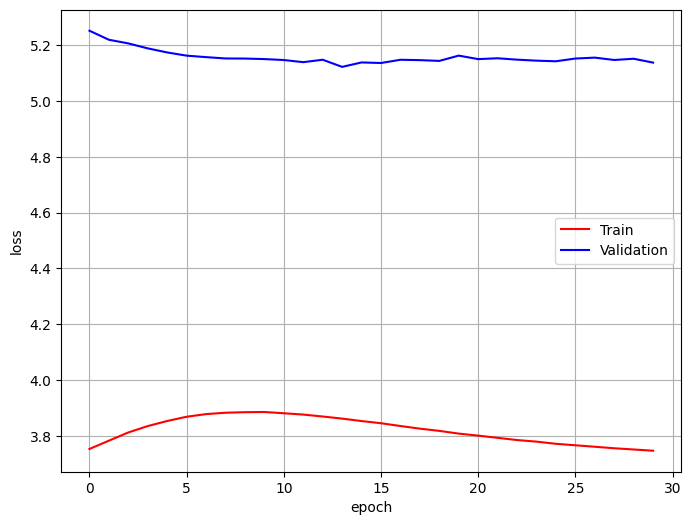

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = "Train")
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = "Validation")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid(True)
plt.legend()

In [6]:
from google.colab import files
uploaded = files.upload()

Saving model.pt to model.pt


## import and test the model

In [50]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [51]:
loss_test, metric_test = loss_valid, metric_valid = evaluate(model,
                                             test_loader,
                                             loss_fn,
                                             metric)
loss_test, metric_test

(5.008470101225393, 149.67527770996094)

In [53]:
prompt = "In a galaxy far, far away, there"

indices = vocab(tokenizer(prompt))
itos = vocab.get_itos()

max_seq_len = 35
for i in range(max_seq_len):
  src = torch.LongTensor(indices).to(device)

  with torch.no_grad():
    prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
  temperature = 0.5
  probs = torch.softmax(prediction[-1]/temperature, dim = 0)

  idx = vocab["<ukn>"]
  while idx == vocab['<ukn']:
    idx = torch.multinomial(probs, num_samples = 1).item()

  token = itos[idx]
  prompt += ' ' + token

  if idx == vocab['.']:
    break

  indices.append(idx)

print(prompt)

In a galaxy far, far away, there is a dispute between the two main characters and the other two men .


# generate function for model

In [56]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim = 0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn']:
      idx = torch.multinomial(probs, num_samples = 1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt


In [61]:
prompt_1 = 'In a galaxy far, far away, there'
generate(prompt_1, 35, 0.5, model, tokenizer, vocab)

'In a galaxy far, far away, there is also evidence that the two films are made with a similar name .'

In [62]:
prompt_2 = 'The sun was setting in the'
generate(prompt_2, 35, 0.5, model, tokenizer, vocab)

'The sun was setting in the same manner as a dark in a set of a long @-@ term type of plum cake , which was used as a generic form in the creation of a single .'

In [63]:
prompt_3 = 'Once upon a time, there lived a young princess named'
generate(prompt_3, 35, 0.5, model, tokenizer, vocab)

'Once upon a time, there lived a young princess named the song .'

In [64]:
prompt_4 = 'What is the meaning '
generate(prompt_4, 35, 0.5, model, tokenizer, vocab)

'What is the meaning  of this novel .'